### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt
from matplotlib import ticker
from yellowbrick.regressor import ResidualsPlot
import statsmodels.api as sm
from statsmodels.api import OLS



#SKLearn stuff
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv('../../data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


### Initial Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

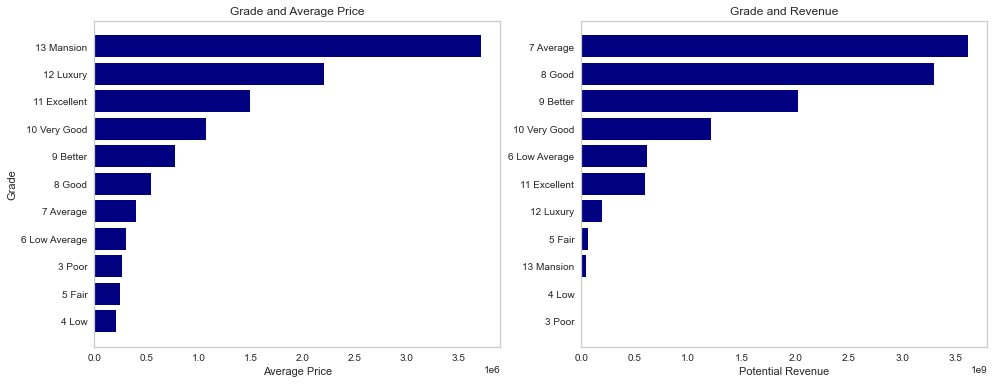

In [5]:
df2 = df.filter(['price', 'grade'])
df2.groupby(['grade']).sum().sort_values(['price'], ascending=False)
grade_vs_price = df2.groupby(['grade']).sum().sort_values(['price'], ascending=False)

fig, (ax2, ax1) = plt.subplots(figsize=(16,6), ncols=2)
ax1.grid(False)
ax2.grid(False)

ax1.barh(y=grade_vs_price.index, width=grade_vs_price['price'], color="navy")
ax1.invert_yaxis()
ax1.set_title('Grade and Revenue')
#ax1.set_ylabel('Grade')
ax1.set_xlabel('Potential Revenue')

grade_vs_price = df2.groupby(['grade']).mean().sort_values(['price'], ascending=False)

ax2.barh(y=grade_vs_price.index, width=grade_vs_price['price'], color="navy")
ax2.invert_yaxis()
ax2.set_title('Grade and Average Price')
ax2.set_ylabel('Grade')
ax2.set_xlabel('Average Price');


Mansion and luxury homes sell for the most but average and good homes account for more of the total potential revenue. 

#### Drops

Dropping 'id', 'yr_renovated', and 'date'. No use for them and we don't have enough data to use them. Dropped row with 33 bedrooms. Created a bedrooms bin column for later use.

In [ ]:
df = df[df['bedrooms'] != 33]

In [ ]:
#Making a categorical bedroom columns
df['bedrooms_bin']=pd.cut(df['bedrooms'], bins = [0,1,2,3,4,5,6,99], labels=['1BR','2BR','3BR','4BR','5BR','6BR','7+BR'])

In [ ]:
df = df.drop(['id', 'date', 'yr_renovated','sqft_basement'], axis=1) 

#### Removing Outliers

Removed outliers base on price and sqft_lot. then removed rows with the value of '3 Poor' and '12 Luxury'. 

In [ ]:
price_q75, price_q25 = np.percentile(df['price'],[75,25])
intr_qrt = price_q75-price_q25
upper_price = price_q75 + (1.5*intr_qrt)
lower_price = price_q25 - (1.5*intr_qrt)
lower_price, upper_price
df = df[df['price'] <= upper_price]
df = df[df['price'] >= lower_price]

In [ ]:
df['sqft_lot'].describe()

In [ ]:
sqft_lot_q75, sqft_lot_q25 = np.percentile(df['sqft_lot'],[75,25])
intr_qrt = sqft_lot_q75-sqft_lot_q25
upper_sqft_lot = sqft_lot_q75 + (1.5*intr_qrt)
lower_sqft_lot = sqft_lot_q25 - (1.5*intr_qrt)
lower_sqft_lot, upper_sqft_lot
df = df[df['sqft_lot'] <= upper_sqft_lot]
df = df[df['sqft_lot'] >= lower_sqft_lot]

In [ ]:
df['grade'].value_counts()

1 record each of grade 2 and Luxury

In [ ]:
df = df[df['grade'] != '3 Poor']
df = df[df['grade'] != '12 Luxury']

### Helper Functions

In [ ]:
def OHE_scale_lr(X_train,y_train,
                 X_test,y_test,
                 
                 num_col,
                 cat_col =[]
                ):
    """
    Creates a pipeline to perform a 
    - One-Hot-Encoding (OHE)
    - Standard Scaling
    - Linear Regression

    cat_col = list of categorical column names to process with OHE. default empty list
    num_col = list of numerical column names
    
    Keep transformations out of this function. Function applid post train-test split
    """
    if not (cat_col or num_col):
        print("no columns provided to perform operations")
        return None
    
    #List Comp to get subst of columns
    list_cols= [col for sublist_cols in [num_col,cat_col]for col in sublist_cols]
    print('Categorical columns:',cat_col,'\nNumerical Columns: ',num_col)
    
    #Create subsets of train and test sets
    X_train_subset = X_train[list_cols]
    X_test_subset = X_test[list_cols]
    
    
    if cat_col:
        X_train_subset,X_test_subset = OHEColXFER(cat_col,X_train_subset, X_test_subset)
    
    pipe = make_pipeline(StandardScaler(), LinearRegression())
    pipe.fit(X_train_subset, y_train) 
    
    train_preds= pipe.predict(X_train_subset)
    test_preds = pipe.predict(X_test_subset)

    print("Training Score:",pipe.score(X_train_subset, y_train))
    print("Test Score:",pipe.score(X_test_subset, y_test))
    get_train_test_metrics(y_train,train_preds,y_test,test_preds)
    

    return X_train_enc,X_test_enc

In [ ]:
def ohe(df, df2, column):    
    for col in column:
        train = df[[col]]
        ohe = OneHotEncoder(drop="first", sparse=False, handle_unknown="error")
        ohe.fit(train)
        encoded_train = ohe.transform(train)
        col_names = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_train = pd.DataFrame(encoded_train,
                                     columns=col_names, index=df.index)
        df = pd.concat([df, encoded_train], axis=1)
        
        test = df2[[col]]
        encoded_test = ohe.transform(test)
        col_names = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_test = pd.DataFrame(encoded_test, 
                                    columns=col_names, index=df2.index)
        df2 = pd.concat([df2, encoded_test], axis=1)
    return df, df2, encoded_train.columns.tolist()

In [ ]:
def scale_n_score(x,y,x2,y2):        
    scaler = StandardScaler()
    scaler.fit(x)
    X_train_scaled = scaler.transform(x)
    X_test_scaled = scaler.transform(x2)

    lr = LinearRegression()
    lr.fit(X_train_scaled,y_train)

    train_preds = lr.predict(X_train_scaled)
    test_preds = lr.predict(X_test_scaled)

    print('Training Score:',r2_score(y_train,train_preds))
    print('Test Score:',r2_score(y_test,test_preds))
    return X_train_scaled, X_test_scaled, train_preds, test_preds

In [ ]:
def get_train_test_metrics(y_train,train_preds,
               y_test,test_preds
              ):
    """
    Prints different training and testing metrics, namely R2, MAE, MSE, RMSE
    """
    print("\nTraining Metrics:")
    print(f"R2: {r2_score(y_train, train_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")
    
    print("\nTesting Metrics:")
    print(f"R2: {r2_score(y_test, test_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

### Split

Using price as a dependent/target variable. 

In [ ]:
y = df["price"]
X = df.drop("price", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)

### Categorical Columns

The column 'waterfront' is a binomial categorical variable. The columns 'bedroom_bin', 'view', 'zipcode', 'condition', and 'grade' are categorical variables. They will need to be converted into a format that can be modeled. 


#### Waterfront

The column contains Yes and No values. I'm assuming NAs are Nos so I will be filling them in as such.

In [ ]:
X_train['waterfront'].fillna('NO', inplace=True)
X_test['waterfront'].fillna('NO', inplace=True)

In [ ]:
waterfront_train = X_train[['waterfront']]
encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(waterfront_train)
encoder_waterfront.categories_[0]
waterfront_encoded_train = encoder_waterfront.transform(waterfront_train)
waterfront_encoded_train = waterfront_encoded_train.flatten()
X_train["waterfront"] = waterfront_encoded_train

In [ ]:
waterfront_test = X_test[['waterfront']]
encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(waterfront_test)
encoder_waterfront.categories_[0]
waterfront_encoded_test = encoder_waterfront.transform(waterfront_test)
waterfront_encoded_test = waterfront_encoded_test.flatten()
X_test["waterfront"] = waterfront_encoded_test

#### View 

The column 'view' has 5 categories; NONE, AVERAGE, GOOD, FAIR, and EXCELLENT. I'm assuming NAs are NONE so I will be filling them in as such.

Created a OneHotEncoder function for the categorical variables. 

Replaced string values for comparative use later in modeling.

In [ ]:
X_train['view'].isna().sum()

In [ ]:
X_train['view'].fillna("NONE", inplace=True)
X_test['view'].fillna("NONE", inplace=True)

The ohe() function takes in a training df, 'df', a test df, 'df2', and a column name, ['column_name']. 

It returns the training df and the test df concatenated with the new encoded columns. It also returns a list of the new encoded column names. 

Example

X_train, X_test, encoded_column_name = ohe(X_train, X_test, ['view'])

In [ ]:
X_train, X_test, encoded_view = ohe(X_train, X_test, ['view'])

In [ ]:
# Change view rating to a numeric value for comparative purposes.
X_train['view'] = X_train['view'].map({'EXCELLENT':5,
                             'GOOD':4,
                             'AVERAGE':3,
                             'FAIR':2,
                             'NONE':1})

In [ ]:
X_test['view'] = X_test['view'].map({'EXCELLENT':5,
                             'GOOD':4,
                             'AVERAGE':3,
                             'FAIR':2,
                             'NONE':1})

#### Condition 

Replaced string values for comparative use later in modeling.

In [ ]:
X_train, X_test, encoded_condition = ohe(X_train, X_test, ['condition'])

In [ ]:
# Change condition rating to a numeric value for comparitive purposes.
X_train['condition'] = X_train['condition'].map({'Very Good':5,
                                       'Good':4,
                                       'Average':3,
                                       'Fair':2,
                                       'Poor':1})

In [ ]:
X_test['condition'] = X_test['condition'].map({'Very Good':5,
                                       'Good':4,
                                       'Average':3,
                                       'Fair':2,
                                       'Poor':1})

#### Grade 

In [ ]:
X_train, X_test, encoded_grade = ohe(X_train, X_test, ['grade'])

#### Zipcode 

In [ ]:
X_train, X_test, encoded_zipcode = ohe(X_train, X_test, ['zipcode'])

#### Bedroom_bins

In [ ]:
X_train, X_test, encoded_bedroom_bin = ohe(X_train, X_test, ['bedrooms_bin'])

### Models

#### Base Model - Dummy Regressor

In [ ]:
dummy = DummyRegressor() #mean strategy
dummy.fit(X_train,y_train)
dummy.score(X_train,y_train)

In [ ]:
dummy.score(X_test,y_test)

#### Model 1

In [ ]:
cols = ['sqft_living']
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [ ]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

#### Model 2

Using columns sqft_living, 'sqft_living15', 'bathrooms', and the columns created from encoding 'zipcode'.

Note the difference between entering the encoding for 'zipcode' and actually entering 'zipcode'. The encoding gives us a higher R2 value, however, it also gives you a much larger RSME Error.

In [ ]:
cols = ['sqft_living', 'bathrooms', 'sqft_living15'] +  encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)


In [ ]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

In [ ]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)

#### Model 3

Using columns  'sqft_living', 'bedrooms', 'sqft_living15', and the columns created from encoding 'zipcode'.

In [ ]:
cols = ['sqft_living', 'bedrooms', 'sqft_living15'] +  encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [ ]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

In [ ]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)

#### Model 4

In [ ]:
cols = ['sqft_living', 'bedrooms'] +  encoded_zipcode + encoded_condition
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [ ]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

In [ ]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)

#### Model 5

Using columns 'sqft_living', 'bedrooms', 'bathrooms', 'condition', 'view', and the columns created from encoding 'zipcode'. 

In [ ]:
cols = ['sqft_living', 'bedrooms', 'bathrooms', 'condition', 'view'] +  encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [ ]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

In [ ]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)

##### model 5

Compared to encoded view and condition.

In [ ]:
cols = ['sqft_living', 'bedrooms', 'bathrooms'] + encoded_condition + encoded_view + encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [ ]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

In [ ]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)

#### Model 6

Using columns 'sqft_living', 'bedrooms', 'bathrooms', 'yr_built' and the columns created from encoding 'condition', 'view', and 'zipcode'. 

In [ ]:
cols = ['sqft_living', 'bedrooms', 'bathrooms', 'yr_built'] + encoded_condition + encoded_view + encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [ ]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

In [ ]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)

In [ ]:
lr = LinearRegression()
visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

In [ ]:
train_residuals = y_train - train_preds
test_residuals = y_test - test_preds
sm.qqplot(train_residuals, line = 'r');

##### Model 6b

In [ ]:
cols = ['sqft_living', 'bathrooms', 'yr_built'] + encoded_bedroom_bin + encoded_condition + encoded_view + encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [ ]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

In [ ]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)

#### Model 7

Using columns 'sqft_living', 'bedrooms', 'bathrooms', 'yr_built' and the columns created from encoding 'condition', 'view', and 'zipcode'. 

In [ ]:
cols = ['sqft_living', 'sqft_living15', 'bedrooms', 'bathrooms', 'yr_built'] + encoded_condition + encoded_view + encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [ ]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

In [ ]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)

I want to take a look at the interaction between sqft_living and sqft_living15.

In [ ]:
lr = LinearRegression()
visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

In [ ]:
train_residuals = y_train - train_preds
test_residuals = y_test - test_preds
sm.qqplot(train_residuals, line = 'r');

##### Model 7b

Using columns 'sqft_living', 'bedrooms', 'bathrooms', 'yr_built' and the columns created from encoding 'bedroom_bin', 'condition', 'view', and 'zipcode'.

In [ ]:
cols = ['sqft_living', 'sqft_living15', 'bathrooms', 'yr_built'] + encoded_bedroom_bin + encoded_condition + encoded_view + encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [ ]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

In [ ]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)

In [ ]:
lr = LinearRegression()
visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()


In [ ]:
train_residuals = y_train - train_preds
test_residuals = y_test - test_preds
sm.qqplot(train_residuals, line = 'r');

#### Model 8

Using columns 'sqft_living', 'bedrooms', 'bathrooms', 'yr_built', 'waterfront' and the columns created from encoding 'bedroom_bin', 'condition', 'view', and 'zipcode'.

In [ ]:
# + encoded_view  , 'waterfront'

In [ ]:
cols = ['sqft_living', 'sqft_living15','bathrooms', 'yr_built'] + encoded_bedroom_bin + encoded_condition+ encoded_zipcode 
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [ ]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

In [ ]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)

In [ ]:
lr = LinearRegression()
visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

In [ ]:
train_residuals = y_train - train_preds
test_residuals = y_test - test_preds
sm.qqplot(train_residuals, line = 'r');

In [ ]:
y = y_train
x = X_train.filter(cols, axis=1)
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

In [ ]:
X_potentials = pd.DataFrame(columns = X_train.columns)

In [ ]:
for num in range(0,1):
    X_potentials = X_potentials.append(
    pd.Series(0, index=X_potentials.columns), 
    ignore_index=True)

In [ ]:
X_potentials['sqft_living'].replace(0,df['sqft_living'].median(),inplace=True)
X_potentials['sqft_living15'].replace(0,df['sqft_living15'].median(),inplace=True)
X_potentials['bathrooms'].replace(0,df.bathrooms.value_counts().index[0],inplace=True)
X_potentials['yr_built'].replace(0,df.yr_built.value_counts().index[0],inplace=True)

X_potentials['bedrooms_bin_x0_3BR'].replace(0,1,inplace=True)

#condition not needed. By default average

X_potentials['zipcode_x0_98103'].replace(0,1,inplace=True)


X_potentials2 = X_potentials

In [ ]:
X_potentials[cols].columns

In [ ]:
X_potentials.filter(cols, axis=1).head(1)

In [ ]:
visualizer.predict(X_potentials[cols])

In [ ]:
lr.predict(X_potentials[cols])

In [ ]:
df['yr_built'].value_counts().head(10)

In [ ]:
vis_data2 = y_test.to_frame().value_counts()
vis_data2

In [ ]:
vis_data = y_test.to_frame().sort_values(by='price', ascending=False)
vis_data['prediction'] = test_preds
vis_data[920:930]

In [ ]:
vis_data = y_test.to_frame()
vis_data['prediction'] = test_preds
vis_data.sort_values(by='price', ascending=False)[925:930]

In [ ]:
# Visualization
y = np.arange(5)
h = 0.6

fig, ax = plt.subplots(figsize=(10,10))


ax.set_title(f'Price vs Predictions')
ax.set_ylabel('Price')
ax.set_xlabel('Examples')

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
ax.bar(y-h/3, vis_data.sort_values(by='price', ascending=False)[925:930]['price'], h/1.5)
ax.bar(y+h/3, vis_data.sort_values(by='price', ascending=False)[925:930]['prediction'], h/1.5, color='orange')

ax.legend(['Actual Price', 'Predicted Price']);
ax.grid(False)

fig.savefig('../../images/price_vs_preds.jpg',
            transparent = False,bbox_inches="tight");

In [ ]:
df['bedrooms'].value_counts()

In [ ]:
df['condition'].value_counts()

In [ ]:
df2 = df.filter(['condition', 'yr_built'])
df2.groupby('condition').median()['yr_built']